In [1]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence
from functools import partial
from tqdm import tqdm
import optax
import lib

In [2]:
class system2d():
    def __init__(self, initial_state, stimulus:lib.stimulus_base_class) -> None:
        self.A , self.B = 10, 1
        self.tau, self.omega = 1, 1
        self.r0 = 1

        self.initial_state = initial_state
        self.stimulus = stimulus
        self.time_range = stimulus.time_range
        self.sol = None

    def dfdt(self, state, t):
        x, y = state[0], state[1]
        t_start, t_end, t_spacing = self.time_range
        t_idx = int(round((t-t_start)/t_spacing))
        t_idx = min(t_idx, int(round((t_end-t_start)/t_spacing))-1)

        tmp = self.r0/np.sqrt((x/self.A)**2+(y/self.B)**2)
        dxdt_intrinsic = - self.A/self.B*self.omega*y - x*(1-tmp)/self.tau
        dydt_intrinsic = + self.B/self.A*self.omega*x - y*(1-tmp)/self.tau
        dxdt = dxdt_intrinsic + self.stimulus.stimulus_list[t_idx]
        return [dxdt, dydt_intrinsic]
    
    def generate_sol(self):
        self.sol = odeint(self.dfdt, self.initial_state, np.arange(*self.time_range))
        

In [3]:
# time_range = (0, 100, 0.01)
# stimulus = lib.constant_stimulus(dc_stimulus=1, time_range=time_range, time_constant=10)

time_range = (0, 100, 0.01)
n_points = len(np.arange(*time_range))
stimulus_list = np.ones(n_points)*(0)

stimulus_list[np.arange(0, 5000)] = 5
stimulus_list[np.arange(5000, 10000)] = 0
stimulus = lib.custom_stimulus(stimulus_list=stimulus_list, time_range=time_range, time_constant=10)

initial_state = [0.5, 0.5]
test_system = system2d(initial_state, stimulus)
test_system.generate_sol()

Text(0, 0.5, 'y')

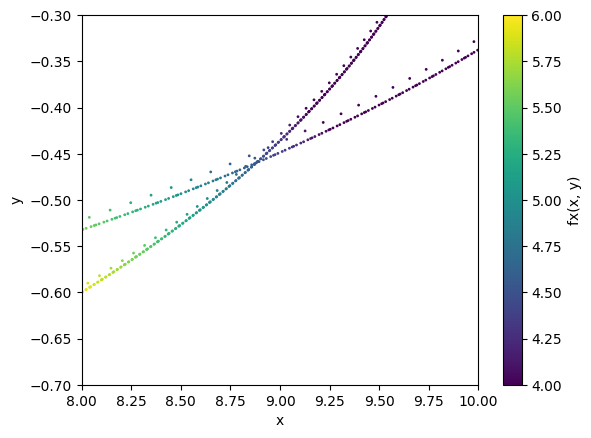

In [6]:
x = test_system.sol[:, 0]
y = test_system.sol[:, 1]
avg_i = (stimulus.stimulus_list[1:]+stimulus.stimulus_list[:-1])/2
dx = x[1:] - x[:-1]
dx = dx/time_range[-1] - avg_i
x = x[:-1]
y = y[:-1]

# plt.scatter(x[:5000], y[:5000], c=dx[:5000], s=1)
# plt.scatter(x[5000:], y[5000:], c=dx[5000:], s=1)

plt.scatter(x[:5000], y[:5000], c=np.clip(dx[:5000], a_min=4, a_max=6), s=1)
plt.scatter(x[5000:], y[5000:], c=np.clip(dx[5000:], a_min=4, a_max=6), s=1)
plt.xlim(8, 10)
plt.ylim(-0.7, -0.3)
plt.colorbar(label="fx(x, y)")
plt.xlabel("x")
plt.ylabel("y")

In [89]:
print(test_system.sol[1205])
print(test_system.sol[7233])
print(test_system.dfdt(test_system.sol[1205], t=1205/time_range[-1]))
print(test_system.dfdt(test_system.sol[7233], t=7233/time_range[-1]))
print(dx[1205])
print(dx[7233])

[ 8.77486054 -0.46947157]
[ 8.80828497 -0.47343542]
[4.737206019276543, 0.8752127400115676]
[4.734354465137214, 0.8808284826182753]
4.673675737943199
4.690233523285059


Text(0, 0.5, 'x(t-τ)')

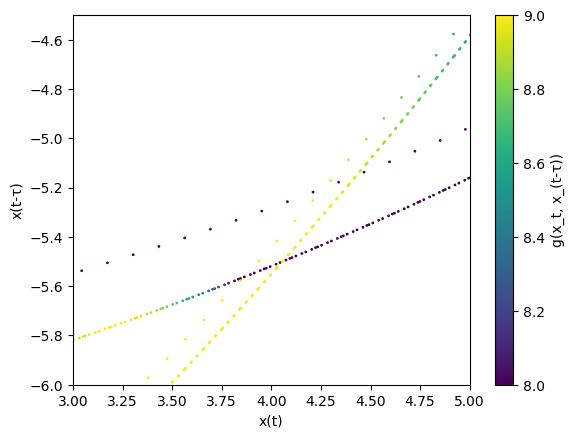

In [7]:
delay = 100
x = test_system.sol[:, 0]
x_delay = x[delay:]
y_delay = x[:-delay]
avg_i = (stimulus.stimulus_list[delay:-1]+stimulus.stimulus_list[delay+1:])/2
dx_delay = x_delay[1:] - x_delay[:-1]
dx_delay = dx_delay/time_range[-1] - avg_i
x_delay = x_delay[:-1]
y_delay = y_delay[:-1]

# plt.scatter(x_delay[:5000], y_delay[:5000], c=dx_delay[:5000], s=1)
# plt.scatter(x_delay[5000:], y_delay[5000:], c=dx_delay[5000:], s=1)

plt.scatter(x_delay[:5000], y_delay[:5000], c=np.clip(dx_delay[:5000], a_min=8, a_max=9), s=1)
plt.scatter(x_delay[5000:], y_delay[5000:], c=np.clip(dx_delay[5000:], a_min=8, a_max=9), s=1)

plt.xlim(3, 5)
plt.ylim(-6, -4.5)
plt.colorbar(label="g(x_t, x_(t-τ))")
plt.xlabel("x(t)")
plt.ylabel("x(t-τ)")